In [1]:
import numpy as np
import pandas as pd
import math as m
import sys
import scipy.stats as stats
from scipy.spatial import distance
from matplotlib import pyplot as plt 
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import random as rn

In [2]:
plt.style.use('../computermodernstyle.mplstyle')

In [3]:
def make_histogram(df, bins):
    n_data = df.shape
    bin_counts, bin_edges = np.histogram(df, bins=bins)
    bin_errors = bin_counts**0.5
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    bin_widths = np.diff(bin_edges)

    # Normalization
    bin_counts_norm = bin_counts/n_data/bin_widths
    bin_errors_norm = bin_errors/n_data/bin_widths

    return bin_counts_norm, bin_errors_norm, bin_edges

In [4]:
def make_histogram_weighted(obs, weights, bins):
    n_data = obs.shape
    bin_counts, bin_edges = np.histogram(obs, bins=bins, weights=weights)
    bin_errors = bin_counts**0.5
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    bin_widths = np.diff(bin_edges)
    
    #return bin_counts, bin_errors, bin_edges

    # Normalization
    bin_counts_norm = bin_counts/n_data/bin_widths
    bin_errors_norm = bin_errors/n_data/bin_widths

    return bin_counts_norm, bin_errors_norm, bin_edges

In [5]:
def make_histogram_with_ratio(df, df_baseline, bins):
    bin_counts, bin_errors, bin_edges = make_histogram(df, bins)
    bin_counts_baseline, _, _ = make_histogram(df_baseline, bins)

    bin_counts_ratio = bin_counts/bin_counts_baseline
    bin_errors_ratio = bin_errors/bin_counts_baseline

    return bin_counts, bin_errors, bin_counts_ratio, bin_errors_ratio, bin_edges

In [6]:
def make_histogram_with_ratio_weighted(obs, weights, obs_baseline, weights_baseline, bins):
    bin_counts, bin_errors, bin_edges = make_histogram_weighted(obs, weights, bins)
    bin_counts_baseline, _, _ = make_histogram_weighted(obs_baseline, weights_baseline, bins)

    bin_counts_ratio = bin_counts/bin_counts_baseline
    bin_errors_ratio = bin_errors/bin_counts_baseline
    return bin_counts, bin_errors, bin_counts_ratio, bin_errors_ratio, bin_edges

In [7]:
# Use the first file as baseline for ratio plot
file_name_gen_samples = '../../pp_to_ttbar/data/generated_samples.csv'
file_name_mc_samples = '../../pp_to_ttbar/data/negative_weight_samples.csv'
# Assume there are 9 weight files
file_name_mc_weights = '../../pp_to_ttbar/data/negative_weight_weights.csv'
edge_colours = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#ffff33", "#a65628", "#f781bf"]

In [8]:
df_mc_samples = pd.read_csv(file_name_mc_samples, delimiter = ',', header=None, index_col=False).to_numpy()[:,:8]

In [9]:
df_gen_samples = pd.read_csv(file_name_gen_samples, delimiter = ',', header=None, index_col=False).to_numpy()[:,:8]

In [10]:
weights = pd.read_csv(file_name_mc_weights, delimiter = ',', header=None, index_col=False).to_numpy()[:,0]

In [11]:
scaling_factor = np.average(weights)

In [12]:
def construct_momentum(x0, x1, x2, x3, E_min, E_max, m_on_shell):
    m = x0*m_on_shell*2
    pT = np.exp(x1*np.log(E_max/E_min))*E_min
    eta = -np.log(np.tan(x2*np.pi/2))
    phi = 2*np.pi*(x3 + 0.5)
    
    return np.sqrt(pT**2 * np.cosh(eta)**2 + m**2), pT*np.cos(phi), pT*np.sin(phi), pT*np.sinh(eta)

In [13]:
def make_physics_from_abstract_data(df_mc_samples, E_min = 0.1, E_max = 6500, m_t = 173):
    moms = np.empty([df_mc_samples.shape[0], 8])

    moms[:,0], moms[:,1], moms[:,2], moms[:,3] = construct_momentum(df_mc_samples[:,0], df_mc_samples[:,1], df_mc_samples[:,2], df_mc_samples[:,3], E_min=E_min, E_max=E_max, m_on_shell=m_t)
    moms[:,4], moms[:,5], moms[:,6], moms[:,7] = construct_momentum(df_mc_samples[:,4], df_mc_samples[:,5], df_mc_samples[:,6], df_mc_samples[:,7], E_min=E_min, E_max=E_max, m_on_shell=m_t)

    return moms

In [14]:
moms_mc = make_physics_from_abstract_data(df_mc_samples)
moms_gen = make_physics_from_abstract_data(df_gen_samples)

## Define plots

In [15]:
obs_mc = []
obs_gen = []
x_min = []
x_max = []
y_max = []
x_label = []
y_label = []
filename = []

**Top mass**

In [16]:
for obs, moms, in ((obs_mc, moms_mc), (obs_gen, moms_gen)):
    obs.append( np.sqrt(moms[:,0]**2 - moms[:,1]**2 - moms[:,2]**2 - moms[:,3]**2) )
x_min.append(167)
x_max.append(180)
y_max.append(1.7)
x_label.append(r'$\mathrm{m_t} [\mathrm{GeV}]$')
y_label.append(r'$\mathrm{\frac{d\sigma}{dm_t}} [\mathrm{pb/GeV}]$')
filename.append("mt.pdf")

**top pt**

In [17]:
for obs, moms, in ((obs_mc, moms_mc), (obs_gen, moms_gen)):
    obs.append( np.sqrt( moms[:,1]**2 + moms[:,2]**2))
x_min.append(0)
x_max.append(480)
y_max.append(9e-2)
x_label.append(r'$p_{T,t} [\mathrm{GeV}]$')
y_label.append(r'$\frac{\mathrm{d}\sigma}{\mathrm{d}p_{T,t}} [\mathrm{pb/GeV}] $')
filename.append("tpt.pdf")

**mtt**

In [18]:
for obs, moms, in ((obs_mc, moms_mc), (obs_gen, moms_gen)):
    obs.append( np.sqrt(
        (moms[:,0] + moms[:,4])**2 - 
        (moms[:,1] + moms[:,5])**2 -
        (moms[:,2] + moms[:,6])**2 - 
        (moms[:,3] + moms[:,7])**2
    ) )

x_min.append(250)
x_max.append(1000)
y_max.append(6e-2)
x_label.append(r'$m_{tt} [\mathrm{GeV}]$')
y_label.append(r'$\frac{\mathrm{d}\sigma}{\mathrm{d}m_{tt}} [\mathrm{pb/GeV}] $')
filename.append("mtt.pdf")

**pt tt**

In [19]:
for obs, moms, in ((obs_mc, moms_mc), (obs_gen, moms_gen)):
    obs.append( np.sqrt( (moms[:,1] + moms[:,5])**2 + (moms[:,2] + moms[:,6])**2 ))
x_min.append(0)
x_max.append(300)
y_max.append(1.2e-1)
x_label.append(r'$p_{T,tt} [\mathrm{GeV}]$')
y_label.append(r'$\frac{\mathrm{d}\sigma}{\mathrm{d}p_{T,tt}} [\mathrm{pb/GeV}] $')
filename.append("pttt.pdf")

**E tt**

In [20]:
for obs, moms, in ((obs_mc, moms_mc), (obs_gen, moms_gen)):
    obs.append( moms[:,0] + moms[:,4] )
x_min.append(346)
x_max.append(3000)
y_max.append(2e-2)
x_label.append(r'$E_{t\bar{t}} [\mathrm{GeV}]$')
y_label.append(r'$\frac{\mathrm{d}\sigma}{\mathrm{d}E_{t\bar{t}}} [\mathrm{pb/GeV}] $')
filename.append("Ett.pdf")

## Make plots

In [21]:
n_bins = 25

[0.22672356 0.24687584 0.2680972  0.29325695 0.32395414 0.36302754
 0.4091221  0.47280169 0.57103946 0.74769896 1.0872634  1.38062823
 1.07133526 0.67518204 0.44402464 0.32080969 0.24307226 0.19281192
 0.15380794 0.13199036 0.11069936 0.09518221 0.08214345 0.07109526
 0.06490699]
[0.22473703 0.24386754 0.2643178  0.29097742 0.31973977 0.35799271
 0.40266082 0.46634442 0.56119379 0.7356749  1.06746003 1.35067223
 1.05518866 0.66811274 0.44979088 0.32470401 0.25018383 0.19734287
 0.1622057  0.13618983 0.11530771 0.09956137 0.08657159 0.07648368
 0.06804446]
[0.2166095  0.23651982 0.25822111 0.28350432 0.31073984 0.34639771
 0.40570919 0.46844123 0.57568915 0.7739534  1.09192162 1.3793951
 1.06694497 0.66502746 0.42797519 0.31088505 0.23632621 0.19026139
 0.16065406 0.13748451 0.11652542 0.0955502  0.08425585 0.07559147
 0.0678145 ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


[0.01130158 0.03246055 0.04742622 0.05481818 0.05450742 0.0495082
 0.04208552 0.03401246 0.02679586 0.02050996 0.01552101 0.0115748
 0.00882356 0.00652407 0.00493734 0.00368329 0.00282956 0.00209509
 0.00161327 0.00124451 0.00098273 0.00074717 0.00057474 0.00046242
 0.00036907]
[0.01120758 0.03201657 0.04681359 0.05405609 0.05425399 0.04957005
 0.04229503 0.03439177 0.02712467 0.02083686 0.0157874  0.01186577
 0.00887446 0.00663317 0.00500257 0.00373662 0.00285856 0.0021339
 0.00163655 0.00125551 0.00095338 0.00074143 0.00058261 0.00046111
 0.00036481]
[0.01200919 0.03148643 0.04634694 0.05359388 0.05364588 0.04954435
 0.04250847 0.03467029 0.02723807 0.0211439  0.01570738 0.01174175
 0.00884586 0.00662773 0.00496501 0.00371611 0.00287055 0.002167
 0.00171298 0.0012891  0.0009819  0.00077783 0.00061877 0.00044092
 0.00038105]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[0.00025735 0.00210223 0.00906358 0.02833615 0.03646936 0.03435473
 0.02973054 0.02485852 0.02049029 0.01663311 0.01354819 0.01098508
 0.00889895 0.00727001 0.00597346 0.00490713 0.00406198 0.00336986
 0.00276012 0.00228985 0.00192866 0.00161412 0.00138637 0.00114996
 0.00098222]
[0.00024114 0.0020455  0.00873674 0.02687871 0.03479377 0.03336931
 0.0294023  0.02489103 0.020645   0.01702662 0.01396325 0.01140524
 0.00933693 0.00764237 0.0062964  0.00516981 0.00428839 0.00354478
 0.00298079 0.00248543 0.00208062 0.00176106 0.00150134 0.0012637
 0.00107009]
[0.0002696  0.00218534 0.00909038 0.02785062 0.03608773 0.03400223
 0.03002841 0.02511881 0.02056215 0.01672956 0.01349154 0.01096613
 0.00888706 0.00730022 0.00592676 0.00489813 0.0040443  0.00332164
 0.00271783 0.00228434 0.00192748 0.00158852 0.00136199 0.00112819
 0.00098751]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[0.07266087 0.1137031  0.10435639 0.08618505 0.06866031 0.05406737
 0.04189001 0.03214757 0.02453862 0.01903687 0.01455536 0.01146484
 0.00908631 0.0073302  0.0060354  0.00489745 0.00410091 0.00338889
 0.00286801 0.00245839 0.00206488 0.0018026  0.00153176 0.00130018
 0.00114194]
[0.05900833 0.10257413 0.1010642  0.08780511 0.07249007 0.05826714
 0.04612045 0.03613787 0.02816095 0.02205757 0.01724209 0.0135182
 0.0107194  0.00848594 0.00667563 0.00527921 0.00417922 0.00332426
 0.00269413 0.00217688 0.00175408 0.00145598 0.00118542 0.00098429
 0.00083205]
[0.06857709 0.11186645 0.10370639 0.08674163 0.06889661 0.05391541
 0.04180921 0.03231792 0.0247158  0.01933356 0.01518187 0.01202859
 0.0095626  0.007786   0.00645617 0.00521234 0.00432439 0.00357977
 0.00310224 0.00264428 0.00213038 0.00190525 0.00159552 0.00139625
 0.00119279]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[1.09469632e-02 1.46700794e-02 1.19964819e-02 9.07779935e-03
 6.79005770e-03 5.12564484e-03 3.96366903e-03 3.07442384e-03
 2.41720262e-03 1.92807784e-03 1.56608224e-03 1.25681930e-03
 1.01942756e-03 8.51669240e-04 6.88501852e-04 5.57789805e-04
 4.57920119e-04 3.74249811e-04 3.05962726e-04 2.52945582e-04
 2.06074525e-04 1.69199798e-04 1.37218639e-04 1.12293948e-04
 8.99488970e-05]
[1.06469952e-02 1.45702851e-02 1.21052059e-02 9.20319630e-03
 6.90376377e-03 5.22460186e-03 4.03115104e-03 3.11423271e-03
 2.44939229e-03 1.95063348e-03 1.56936341e-03 1.25439947e-03
 1.01142530e-03 8.33857756e-04 6.74833780e-04 5.48814594e-04
 4.45727756e-04 3.63161417e-04 2.93909678e-04 2.39257542e-04
 1.94964502e-04 1.57956436e-04 1.26286071e-04 1.02523414e-04
 8.16272994e-05]
[1.09662314e-02 1.47541003e-02 1.20576700e-02 9.13789391e-03
 6.82042437e-03 5.12810178e-03 3.93826773e-03 3.03050061e-03
 2.38354070e-03 1.89330220e-03 1.48430909e-03 1.20366474e-03
 9.77394735e-04 7.90878072e-04 6.34472785e-04 5.345

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


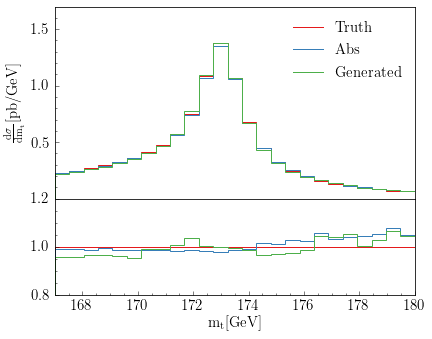

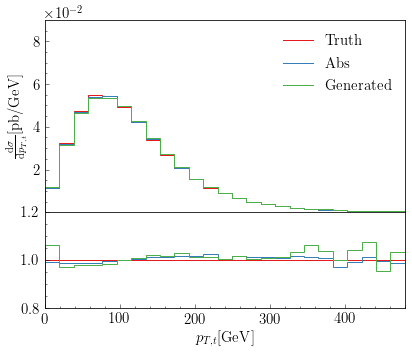

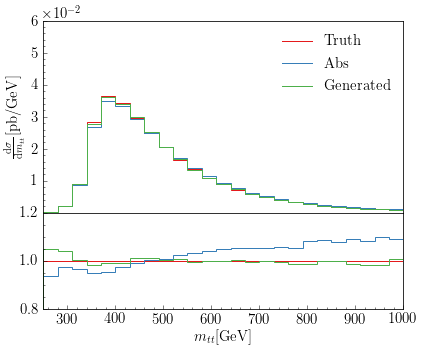

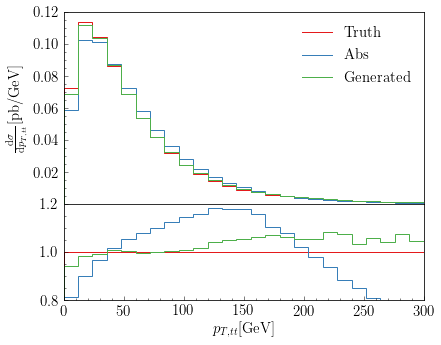

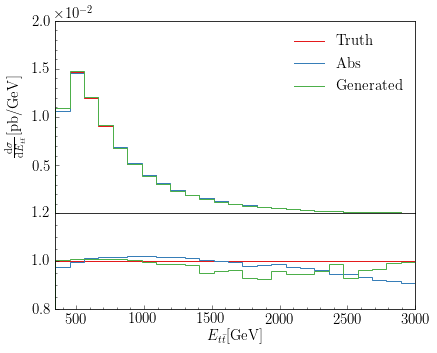

In [22]:
for i in range(len(obs_mc)):
    fig = plt.figure()
    fig.set_size_inches(5,4)
    gs = gridspec.GridSpec(nrows=3,ncols=1)
    gs.update(left=0,right=1,top=1,bottom=0,hspace=0, wspace=0)

    main_plot = fig.add_subplot(gs[:-1,0])
    ratio_plot = fig.add_subplot(gs[2,0])

    main_plot.set_xlim(x_min[i], x_max[i])
    main_plot.set_ylim(0.0001, y_max[i])
    main_plot.set_xticks([])
    ratio_plot.set_xlim(x_min[i], x_max[i])
    ratio_plot.set_ylim(0.8,1.2)
    bins = np.linspace(x_min[i], x_max[i], n_bins+1)
    bin_centers = (bins[:-1] + bins[1:])/2

    counts_train, errors_train, edges = make_histogram_weighted(obs_mc[i], weights, bins)
    print(counts_train)
    counts_abs, errors_abs, _ = make_histogram_weighted(obs_mc[i], scaling_factor*np.ones(len(obs_mc[i])), bins)
    print(counts_abs)
    counts_gen, errors_gen, _ = make_histogram_weighted(obs_gen[i], scaling_factor*np.ones(len(obs_gen[i])), bins)
    print(counts_gen)
    
    # Main plot
    main_plot.hist(edges[:-1], edges, weights=counts_train, edgecolor = edge_colours[0], histtype="step", label="Truth")
    main_plot.hist(edges[:-1], edges, weights=counts_abs, edgecolor = edge_colours[1], histtype="step", label="Abs")
    main_plot.hist(edges[:-1], edges, weights=counts_gen, edgecolor = edge_colours[2], histtype="step", label="Generated")

    # Ratio plot
    counts_train_fixed = counts_train
    counts_train_fixed[counts_train_fixed == 0] = 1

    counts_abs_fixed = counts_abs
    counts_abs_fixed[counts_abs_fixed == 0] = 1
    
    counts_gen_fixed = counts_gen
    counts_gen_fixed[counts_gen_fixed == 0] = 1

    ratio_abs = counts_abs_fixed/counts_train_fixed
    ratio_gen = counts_gen_fixed/counts_train_fixed
    
    ratio_plot.hist(edges[:-1], edges, weights=np.ones(len(counts_train)), edgecolor=edge_colours[0], histtype="step")
    ratio_plot.hist(edges[:-1], edges, weights=ratio_abs, edgecolor=edge_colours[1], histtype="step")
    ratio_plot.hist(edges[:-1], edges, weights=ratio_gen, edgecolor=edge_colours[2], histtype="step")
    
    handles, labels = main_plot.get_legend_handles_labels()
    new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
    main_plot.legend(loc=1, handles=new_handles, labels=labels) 

    ratio_plot.set_xlabel(x_label[i])
    main_plot.set_ylabel(y_label[i])
    plt.savefig('{}.pdf'.format(filename[i]), format='pdf', dpi=1000, bbox_inches = "tight")